# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://ramp.r0h.eu/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
# !pip install -U seaborn  # if you don't have it, or pip3 for python3

In [3]:
# optional
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

First we load `problem.py` that parameterizes the challenge. It contains some objects taken off the shelf from `ramp-workflow` (e.g., `Predictions` type, scores, and data reader). 

In [4]:
problem = imp.load_source('', 'problem.py')

`get_train_data` loads the training data and returns an `pandas` object (input) and a `np.array` object (output).

In [5]:
X_df, y_array = problem.get_train_data()

## Preprocessing for prediction

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

In [46]:
X_encoded = X_df

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
X_encoded = X_encoded.drop('Departure', axis=1)
X_encoded = X_encoded.drop('Arrival', axis=1)

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

In [47]:
X_encoded.tail(5)

,DateOfDeparture,WeeksToDeparture,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
8897,2011-10-02,9.263158,7.316967,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,10,2,6,39,15249,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,2012-09-25,12.772727,10.641034,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2012,9,25,1,39,15608,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8899,2012-01-19,11.047619,7.908705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2012,1,19,3,3,15358,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8900,2013-02-03,6.076923,4.030334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2013,2,3,6,5,15739,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8901,2011-11-26,9.526316,6.167733,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,11,26,5,47,15304,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### A linear regressor baseline

We drop the target column and the original data column.

In [48]:
#we drop values that we don't care
X_encoded = X_encoded.drop(['year', 'month', 'day', 'weekday', 'week', 'n_days'], axis=1)
X_encoded.tail(5)

,DateOfDeparture,WeeksToDeparture,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
8897,2011-10-02,9.263158,7.316967,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,2012-09-25,12.772727,10.641034,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8899,2012-01-19,11.047619,7.908705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8900,2013-02-03,6.076923,4.030334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8901,2011-11-26,9.526316,6.167733,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [56]:
features = X_encoded.drop(['DateOfDeparture'], axis=1)
X_columns = features.columns
X_array = features.values
features.head()

,WeeksToDeparture,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,9.812647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,9.035883,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,7.990202,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,9.517159,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(X_encoded.iloc[:, 1:], axis=0)
X_scaled[1,:]

array([ 1.01875226,  0.39680658, -0.35373209, -0.24626363, -0.13571641,
       -0.27832191, -0.2801917 , -0.16212788, -0.21972878, -0.12640446,
       -0.20647744,  4.49953591, -0.30508139, -0.23503074, -0.15237582,
       -0.16394322, -0.16285619, -0.36330964, -0.20350232, -0.12594502,
       -0.18020839, -0.29055041, -0.35573901, -0.26351047, -0.12594502,
        3.67080328, -0.25860085, -0.14965218, -0.22057016, -0.12686234,
       -0.18415769, -0.22693637, -0.30639935, -0.24291042, -0.1825212 ,
       -0.15656868, -0.15429448, -0.37568039, -0.20677298, -0.12502139,
       -0.17786934, -0.29032302, -0.54402885,  0.71905603, -0.35593935,
       -0.35714014, -0.32532831, -0.26931417, -0.25110218, -0.23316209,
       -0.23952084, -0.24575006, -0.23978291,  2.85136045, -0.35633986,
       -0.35593935, -0.35593935, -0.19184395, -0.18642778, -0.19372439,
       -0.19558934, -0.19558934, -0.1883547 , -0.19089778, -0.17345209,
       -0.17719607,  5.46897817, -0.18020839, -0.18899323, -0.18

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_array, test_size=0.2, random_state=0)

It gives us a pretty nice improvement above baseline

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

scores = cross_val_score(
    reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6379 +/- 0.0058


Exercise: Visualize the coefficients, try to make sense of them.

In [52]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
reg.coef_

array([ 1.26751647e-01, -7.82532465e-02, -1.43707368e+10, -1.43707368e+10,
       -1.43707368e+10, -1.43707368e+10, -1.43707368e+10, -1.43707368e+10,
       -1.43707368e+10, -1.43707368e+10, -1.43707368e+10, -1.43707368e+10,
       -1.43707368e+10, -1.43707368e+10, -1.43707368e+10, -1.43707368e+10,
       -1.43707368e+10, -1.43707368e+10, -1.43707368e+10, -1.43707368e+10,
       -1.43707368e+10, -1.43707368e+10, -8.44780204e+09, -8.44780204e+09,
       -8.44780204e+09, -8.44780204e+09, -8.44780204e+09, -8.44780204e+09,
       -8.44780204e+09, -8.44780204e+09, -8.44780204e+09, -8.44780204e+09,
       -8.44780204e+09, -8.44780204e+09, -8.44780204e+09, -8.44780204e+09,
       -8.44780204e+09, -8.44780204e+09, -8.44780204e+09, -8.44780204e+09,
       -8.44780204e+09, -8.44780204e+09, -1.04962861e+10, -1.04962861e+10,
       -1.04962861e+10, -4.70855899e+08, -4.70855899e+08, -4.70855899e+08,
       -4.70855900e+08, -4.70855900e+08, -4.70855899e+08, -4.70855900e+08,
       -4.70855900e+08, -

## Random Forests

In [72]:
%%time
from sklearn.ensemble import RandomForestRegressor

n_estimators = 10
max_depth = 10
max_features = 10
reg = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

scores = cross_val_score(
    reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.7869 +/- 0.0116
CPU times: user 79.8 ms, sys: 89.8 ms, total: 170 ms
Wall time: 3.41 s


## Variable importances

In [73]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [74]:
len(X_columns)

147

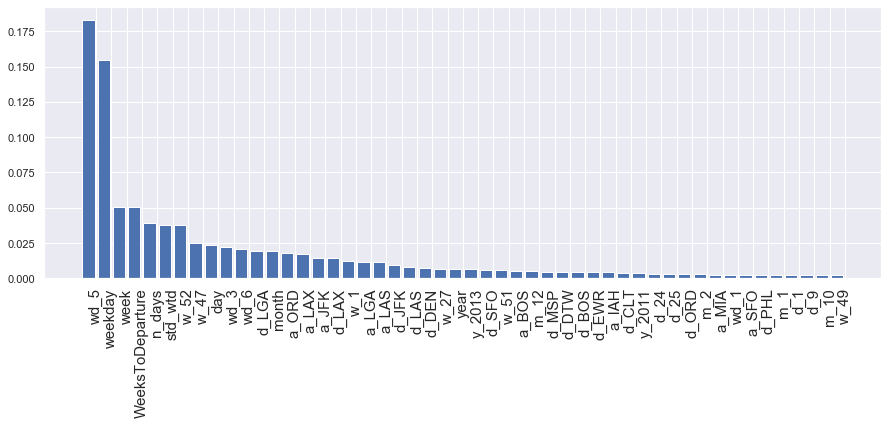

In [26]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

## Building predictive models

### The feature extractor

The feature extractor implements a single <code>transform</code> function. It receives the full pandas object X_df (without the labels). It should produce a numpy array representing the features extracted. If you want to use the (training) labels to save some state of the feature extractor, you can do it in the fit function.

The starting kit feature extractor shows you how to join your data to external data. You will have the possibility to submit a single external csv for each of your submission (so if you have several data sets, you first have to do the join offline, and save it as a csv). In this case it is whether data, joined to the database on the <code>DateOfDeparture</code> and <code>Arrival</code> fields. Attention: when you join the data, make sure that the <b><font color=red>order</font> of the rows in the data frame does not change</b>.

In [75]:
import pandas as pd
import os


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        path = os.path.dirname(__file__)
        data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
        X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
        X_weather = X_weather.rename(
            columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
        X_encoded = pd.merge(
            X_encoded, X_weather, how='left',
            left_on=['DateOfDeparture', 'Arrival'],
            right_on=['DateOfDeparture', 'Arrival'],
            sort=False)

        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)

        X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
        X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
        X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
        X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
        X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
        X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
        X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

        X_encoded = X_encoded.drop(['year', 'month', 'day', 'weekday', 'week', 'n_days'], axis=1)

        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
        X_array = X_encoded.values
        return X_array

In [76]:
# we need this because the global variable __file__ (the path of the current file)
# does not exist if we are in a notebook
__file__ = 'submissions/starting_kit/'
fe = FeatureExtractor()
fe.fit(X_df, y_array)
X_array = fe.transform(X_df)
X_array.shape

(8902, 148)

### The regressor

The regressor should implement an sklearn-like regressor with `fit` and `predict` functions.

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = LinearRegression()

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

In [78]:
reg = Regressor()
reg.fit(X_array, y_array)
y_pred = reg.predict(X_array)

In [79]:
score_type = problem.score_types[0]

In [80]:
score = score_type(y_array, y_pred)
score

0.6215618048444432

In [81]:
X_test_df, y_test_array = problem.get_test_data()

In [82]:
X_test_array = fe.transform(X_test_df)
y_test_pred = reg.predict(X_test_array)
score_type(y_test_array, y_test_pred)

0.6581581463335616

In [83]:
cv = problem.get_cv(X_df, y_array)

In [84]:
for fold in cv:
    print(fold)

(array([1527, 1304, 4252, ..., 3151, 3077, 3023]), array([5590, 2344,  938, ..., 6220, 4046,  958]))
(array([2836, 8896, 8801, ..., 2919, 1608, 2510]), array([  97, 5215, 8350, ..., 3136, 7833, 4932]))
(array([7366, 8531, 7566, ..., 3948, 6159, 8204]), array([2696, 3742, 2039, ..., 7243,  898, 8388]))
(array([2275, 4121, 8842, ..., 4813, 8347, 7834]), array([3557, 4733, 6513, ..., 3732, 8590, 3621]))
(array([2234, 6933, 7735, ..., 1954, 2590, 8468]), array([8403, 2539, 6318, ..., 7136, 2123,  787]))
(array([1337, 4654, 5750, ..., 6708, 6032, 4680]), array([1148, 4736, 3175, ...,  342, 4437, 5412]))
(array([4393, 4923, 7190, ...,  418, 7477, 2455]), array([8019, 2236, 6463, ..., 4189, 8555, 6438]))
(array([8464, 3308, 6072, ..., 3662, 2696, 5690]), array([8298, 4113, 8879, ..., 3936, 3903, 4337]))


In [85]:
cv = problem.get_cv(X_df, y_array)
valid_scores = np.array([])
for fold in cv:
    train_is, valid_is = fold
    X_fold_train = X_df.iloc[train_is]
    y_fold_train = y_array[train_is]
    X_fold_valid = X_df.iloc[valid_is]
    y_fold_valid = y_array[valid_is]
    fe.fit(X_fold_train, y_fold_train)
    X_fold_train_array = fe.transform(X_fold_train)
    reg.fit(X_fold_train_array, y_fold_train)
    X_fold_valid_array = fe.transform(X_fold_valid)
    y_fold_valid_pred = reg.predict(X_fold_valid_array)
    valid_score = score_type(y_fold_valid, y_fold_valid_pred)
    valid_scores = np.append(valid_scores, valid_score)
print('validation scores =', valid_scores)
print('validation score mean =', valid_scores.mean())
print('validation score std =', valid_scores.std())

validation scores = [0.63277533 0.64086199 0.63941276 0.65462664 0.63366847 0.63724822
 0.63543891 0.62676704]
validation score mean = 0.6375999207558838
validation score std = 0.007621635965488088


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py`, `regressor.py`, and `external_data.csv` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.bz2` and `test.csv.bz2` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [4]:
!ramp_test_submission

Testing Number of air passengers prediction
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score   rmse      time
	train  0.238  1.855965
	valid  0.592  1.743794
	test   0.604  0.425864
CV fold 1
	score   rmse      time
	train  0.223  1.636310
	valid  0.593  1.438196
	test   0.604  0.416110
CV fold 2
	score   rmse      time
	train  0.231  1.787300
	valid  0.604  1.513663
	test   0.611  0.418389
CV fold 3
	score   rmse      time
	train  0.227  1.579414
	valid  0.586  1.458985
	test   0.597  0.462179
CV fold 4
	score   rmse      time
	train  0.239  1.939813
	valid  0.600  1.669781
	test   0.613  0.432410
CV fold 5
	score   rmse      time
	train  0.230  1.590329
	valid  0.582  1.440331
	test   0.604  0.416559
CV fold 6
	score   rmse      time
	train  0.230  1.594678
	valid  0.591  1.468275
	test   0.608  0.414469
CV fold 7
	score   rmse      time
	train  0.229  1.605692
	valid  0.568  1.447967
	test   0.594  0.417128
----------

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [7]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

"""Provide utils to test ramp-kits."""
from __future__ import print_function

import os
import imp

import numpy as np
import pandas as pd

from .combine import blend_on_fold
from .io import load_y_pred
from .pretty_print import print_title, print_df_scores
from .notebook import execute_notebook, convert_notebook
from .scoring import round_df_scores, mean_score_matrix
from .submission import (bag_submissions, run_submission_on_cv_fold,
                         run_submission_on_full_train)


def assert_notebook(ramp_kit_dir='.'):
    print('----------------------------')
    convert_notebook(ramp_kit_dir)
    execute_notebook(ramp_kit_dir)


def assert_read_problem(ramp_kit_dir='.'):
    # giving a random name to the module so it passes looped tests
    module_name = str(int(1000000000 * np.random.rand()))
    problem = imp.load_source(module_name,
                              os.path.join(ramp_kit_dir, 'problem.py'))
    return problem


def assert_title(ramp_kit_dir='.'):
    problem = assert_read_problem(ramp_kit_dir)
    print_title('Testing {}'.format(problem.problem_title))


def assert_data(ramp_kit_dir='.', ramp_data_dir='.'):
    problem = assert_read_problem(ramp_kit_dir)
    print_title('Reading train and test files from {}/data ...'.format(
        ramp_data_dir))
    X_train, y_train = problem.get_train_data(path=ramp_data_dir)
    X_test, y_test = problem.get_test_data(path=ramp_data_dir)
    return X_train, y_train, X_test, y_test


def assert_cv(ramp_kit_dir='.', ramp_data_dir='.'):
    problem = assert_read_problem(ramp_kit_dir)
    X_train, y_train = problem.get_train_data(path=ramp_data_dir)
    print_title('Reading cv ...')
    cv = list(problem.get_cv(X_train, y_train))
    return cv


def assert_score_types(ramp_kit_dir='.'):
    problem = assert_read_problem(ramp_kit_dir)
    score_types = problem.score_types
    return score_types


def assert_submission(ramp_kit_dir='.', ramp_data_dir='.',
                      ramp_submission_dir='submissions',
                      submission='starting_kit', is_pickle=False,
                      save_output=False, retrain=False):
    """Helper to test a submission from a ramp-kit.

    Parameters
    ----------
    ramp_kit_dir : str, default='.'
        The directory of the ramp-kit to be tested for submission.
    ramp_data_dir : str, default='.'
        The directory of the data.
    ramp_submission_dir : str, default='./submissions'
        The directory of the submissions.
    submission : str, default='starting_kit'
        The name of the submission to be tested.
    is_pickle : bool, default is False
        Whether to pickle the model or not.
    save_y_preds : bool, default is False
        Whether to store the predictions.
    retrain : bool, default is False
        Whether to train the model on the full training set and test on the
        test set.
    """
    problem = assert_read_problem(ramp_kit_dir)
    assert_title(ramp_kit_dir)
    X_train, y_train, X_test, y_test = assert_data(ramp_kit_dir, ramp_data_dir)
    cv = assert_cv(ramp_kit_dir, ramp_data_dir)
    score_types = assert_score_types(ramp_kit_dir)

    # module_path = os.path.join(ramp_kit_dir, 'submissions', submission)
    submission_path = os.path.join(ramp_submission_dir, submission)
    print_title('Training {} ...'.format(submission_path))

    training_output_path = ''
    if is_pickle or save_output:
        # creating <submission_path>/<submission>/training_output dir
        training_output_path = os.path.join(submission_path, 'training_output')
        if not os.path.exists(training_output_path):
            os.makedirs(training_output_path)

    # saving predictions for CV bagging after the CV loop
    predictions_valid_list = []
    predictions_test_list = []
    df_scores_list = []

    for fold_i, fold in enumerate(cv):
        fold_output_path = ''
        if is_pickle or save_output:
            # creating <submission_path>/<submission>/training_output/fold_<i>
            fold_output_path = os.path.join(
                training_output_path, 'fold_{}'.format(fold_i))
            if not os.path.exists(fold_output_path):
                os.makedirs(fold_output_path)
        print_title('CV fold {}'.format(fold_i))

        predictions_valid, predictions_test, df_scores = \
            run_submission_on_cv_fold(
                problem, submission_path, fold, X_train, y_train,
                X_test, y_test, is_pickle, save_output, fold_output_path,
                ramp_data_dir)
        if save_output:
            filename = os.path.join(fold_output_path, 'scores.csv')
            df_scores.to_csv(filename)
        df_scores_rounded = round_df_scores(df_scores, score_types)
        print_df_scores(df_scores_rounded, indent='\t')

        # saving predictions for CV bagging after the CV loop
        df_scores_list.append(df_scores)
        predictions_valid_list.append(predictions_valid)
        predictions_test_list.append(predictions_test)

    print_title('----------------------------')
    print_title('Mean CV scores')
    print_title('----------------------------')
    df_mean_scores = mean_score_matrix(df_scores_list, score_types)
    print_df_scores(df_mean_scores, indent='\t')

    if retrain:
        # We retrain on the full training set
        print_title('----------------------------')
        print_title('Retrain scores')
        print_title('----------------------------')
        run_submission_on_full_train(
            problem, submission_path, X_train, y_train, X_test, y_test,
            score_types, is_pickle, save_output, training_output_path,
            ramp_data_dir)
    bag_submissions(
        problem, cv, y_train, y_test, predictions_valid_list,
        predictions_test_list, training_output_path,
        ramp_data_dir=ramp_data_dir, score_type_index=None,
        save_output=save_output)


def blend_submissions(submissions, ramp_kit_dir='.', ramp_data_dir='.',
                      ramp_submission_dir='.', save_output=False,
                      min_improvement=0.0):
    problem = assert_read_problem(ramp_kit_dir)
    print_title('Blending {}'.format(problem.problem_title))
    X_train, y_train, X_test, y_test = assert_data(ramp_kit_dir, ramp_data_dir)
    cv = assert_cv(ramp_kit_dir, ramp_data_dir)
    valid_is_list = [valid_is for (train_is, valid_is) in cv]
    score_types = assert_score_types(ramp_kit_dir)
    contributivitys = np.zeros(len(submissions))

    combined_predictions_valid_list = []
    foldwise_best_predictions_valid_list = []
    combined_predictions_test_list = []
    foldwise_best_predictions_test_list = []
    for fold_i, valid_is in enumerate(valid_is_list):
        print_title('CV fold {}'.format(fold_i))
        ground_truths_valid = problem.Predictions(y_true=y_train[valid_is])
        predictions_valid_list = []
        predictions_test_list = []
        for submission in submissions:
            module_path = os.path.join(ramp_submission_dir, submission)
            training_output_path = os.path.join(module_path, 'training_output')
            fold_output_path = os.path.join(
                training_output_path, 'fold_{}'.format(fold_i))
            y_pred_train = load_y_pred(
                problem, data_path=ramp_data_dir,
                input_path=fold_output_path, suffix='train')
            y_pred_test = load_y_pred(
                problem, data_path=ramp_data_dir,
                input_path=fold_output_path, suffix='test')
            predictions_valid = problem.Predictions(
                y_pred=y_pred_train[valid_is])
            predictions_valid_list.append(predictions_valid)
            predictions_test = problem.Predictions(y_pred=y_pred_test)
            predictions_test_list.append(predictions_test)

        best_index_list = blend_on_fold(
            predictions_valid_list, ground_truths_valid, score_types[0],
            min_improvement=min_improvement)

        # we share a unit of 1. among the contributive submissions
        unit_contributivity = 1. / len(best_index_list)
        for i in best_index_list:
            contributivitys[i] += unit_contributivity

        combined_predictions_valid_list.append(
            problem.Predictions.combine(predictions_valid_list))
        foldwise_best_predictions_valid_list.append(predictions_valid_list[0])
        combined_predictions_test_list.append(
            problem.Predictions.combine(predictions_test_list))
        foldwise_best_predictions_test_list.append(predictions_test_list[0])

    contributivitys /= len(cv)
    contributivitys_df = pd.DataFrame()
    contributivitys_df['submission'] = np.array(submissions)
    contributivitys_df['contributivity'] = np.round(contributivitys, 3)
    contributivitys_df = contributivitys_df.reset_index()
    contributivitys_df = contributivitys_df.sort_values(
        'contributivity', ascending=False)
    print(contributivitys_df.to_string(index=False))

    training_output_path = os.path.join(ramp_kit_dir, 'training_output')
    if not os.path.exists(training_output_path):
        os.mkdir(training_output_path)
    # bagging the foldwise ensembles
    bag_submissions(
        problem, cv, y_train, y_test, combined_predictions_valid_list,
        combined_predictions_test_list, training_output_path,
        ramp_data_dir=ramp_data_dir, score_type_index=0,
        save_output=save_output, score_table_title='Combined bagged scores',
        score_f_name_prefix='foldwise_best')
    # bagging the foldwise best submissions
    bag_submissions(
        problem, cv, y_train, y_test, foldwise_best_predictions_valid_list,
        foldwise_best_predictions_test_list, training_output_path,
        ramp_data_dir=ramp_data_dir, score_type_index=0,
        save_output=save_output,
        score_table_title='Foldwise best bagged scores',
        score_f_name_prefix='combined')


ModuleNotFoundError: No module named '__main__.combine'; '__main__' is not a package

In [ ]:
#assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://ramp.r0h.eu). First, if it is your first time using RAMP, [sign up](http://ramp.r0h.eu/sign_up), otherwise [log in](http://ramp.r0h.eu/login). Then find an open event on the particular problem, for example, the event [DSSP 6](https://ramp.r0h.eu/events/air_passengers_dsb2019) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://ramp.r0h.eu/events/air_passengers_dsb2019/sandbox) and copy-paste (or upload) [`feature_extractor.py`](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py), [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py), and [`external_data.csv`](http://localhost:8890/edit/submissions/starting_kit/external_data.csv) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://ramp.r0h.eu/events/air_passengers_dsb2019/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://ramp.r0h.eu/events/air_passengers_dsb2019/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://ramp.r0h.eu/events/air_passengers_dsb2019/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.748 ± 0.0117
valid rmse = 0.858 ± 0.0111
test rmse = 0.881 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://ramp.r0h.eu/events/air_passengers_dsb2019/leaderboard)) is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.858 ± 0.0111`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=air passengers notebook).